In [1]:
import pandas as pd
import wandb
from tqdm.notebook import tqdm
import pickle
import torch
from os.path import exists
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import MaxNLocator
from seaborn import heatmap
from gpytorch.kernels import ScaleKernel, RBFKernel
from gp.soft_gp.soft_gp import SoftGP

from data.get_uci import all_datasets
from analysis.util import fetch, init_uci_dict, get_uci_info

In [2]:
filters = {
    "group": "benchmark7"
}
raw = fetch("soft-gp-2", filters)

100%|██████████| 38/38 [00:16<00:00,  2.33it/s]


In [3]:
uci_info = get_uci_info()

In [4]:
uci_dict = {}
for exp in raw:
    model = exp.config["model.name"]
    dataset = exp.config["dataset.name"]
    dtype = exp.config["model.dtype"]
    seed = exp.config["training.seed"]
    train_frac = float(exp.config["dataset.train_frac"])
    uci_dict[(dataset, seed, model)] = exp.history

print(uci_dict.keys())

dict_keys([('elevators', 6535, 'exact'), ('pol', 6535, 'exact'), ('houseelectric', 92357, 'soft-gp'), ('houseelectric', 8830, 'soft-gp'), ('houseelectric', 6535, 'soft-gp'), ('buzz', 92357, 'soft-gp'), ('buzz', 8830, 'soft-gp'), ('buzz', 6535, 'soft-gp'), ('song', 92357, 'soft-gp'), ('song', 8830, 'soft-gp'), ('song', 6535, 'soft-gp'), ('3droad', 92357, 'soft-gp'), ('3droad', 8830, 'soft-gp'), ('3droad', 6535, 'soft-gp'), ('keggundirected', 92357, 'soft-gp'), ('keggundirected', 8830, 'soft-gp'), ('keggundirected', 6535, 'soft-gp'), ('slice', 92357, 'soft-gp'), ('slice', 8830, 'soft-gp'), ('slice', 6535, 'soft-gp'), ('keggdirected', 92357, 'soft-gp'), ('keggdirected', 8830, 'soft-gp'), ('keggdirected', 6535, 'soft-gp'), ('protein', 92357, 'soft-gp'), ('protein', 8830, 'soft-gp'), ('protein', 6535, 'soft-gp'), ('kin40k', 92357, 'soft-gp'), ('kin40k', 8830, 'soft-gp'), ('kin40k', 6535, 'soft-gp'), ('bike', 92357, 'soft-gp'), ('bike', 8830, 'soft-gp'), ('bike', 6535, 'soft-gp'), ('elevator

In [5]:
seeds = [6535, 8830, 92357]
num_inducings = [512]
tmp = {
    "N": [int(np.floor(N * 0.9)) for _, N, _, _ in uci_info],
    "D": [D for _, _, D, _ in uci_info],
}
models = ["soft-gp"]

for seed in seeds:
    for model in models:
        xs = []
        ts = []
        ls = []
        for dataset, _, _, _ in uci_info:
            try:
                xs += [uci_dict[(dataset, seed, model)]["test_rmse"][49]]
                ts += [np.array(uci_dict[(dataset, seed, model)]["epoch_time"][49]).mean()]
                ls += [uci_dict[(dataset, seed, model)]["lengthscale"][49]]
            except Exception as e:
                xs += [np.nan]
                ts += [np.nan]
                ls += [np.nan]
                print("Exception", e, model, dataset)

        tmp[f"{model}-{seed}"] = xs
        tmp[f"time-{model}-{seed}"] = ts
        tmp[f"time-{model}-{seed}"] = ts
df = pd.DataFrame(data=tmp)
df.index = [name.capitalize().replace("_", "-") for name, _, _, _ in uci_info]
df

,N,D,soft-gp-6535,time-soft-gp-6535,soft-gp-8830,time-soft-gp-8830,soft-gp-92357,time-soft-gp-92357
Pol,13500,26,0.189090,0.917688,0.201634,0.949362,0.194142,1.004369
Elevators,14939,18,0.391163,1.070552,0.397475,1.042269,0.377955,1.003453
Bike,15641,17,0.207340,1.080615,0.207691,1.057707,0.197687,1.026268
Kin40k,36000,8,0.242822,2.590711,0.228540,2.540294,0.240351,2.630915
Protein,41157,9,0.656439,2.685682,0.637273,2.701648,0.652695,2.642476
Keggdirected,43944,20,0.078730,2.953385,0.077663,3.016233,0.086821,2.957597
Slice,48150,385,0.050872,3.313494,0.046226,3.369051,0.049981,3.317592
Keggundirected,57247,27,0.116529,3.694599,0.110729,3.612519,0.118467,3.686946
3droad,391386,3,0.605115,24.494310,0.600449,24.257876,0.605276,24.377816
Song,270000,90,0.799294,17.721366,0.789860,17.350316,0.791015,17.461972


In [6]:
api = wandb.Api()
for exp in tqdm(raw):
    run = api.run(f'bogp/soft-gp-2/{exp.run.id}')
    if exp.config["training.seed"] == 6535:
        for artifact in run.logged_artifacts():
            print(artifact.name)
            artifact.download()


  0%|          | 0/38 [00:00<?, ?it/s]

run-cnfrhb96-history:v0


wandb:   1 of 1 files downloaded.  


run-fyqdmbkx-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-74db646q-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-kx5m73hs-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-v22l4p14-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-uo923rn7-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_keggundirected_512_1024_0.001_6535_0:v0


wandb: Downloading large artifact W_xz_softgp_keggundirected_512_1024_0.001_6535_0:v0, 111.81MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_keggundirected_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_keggundirected_512_1024_0.001_6535_10:v0


wandb: Downloading large artifact W_xz_softgp_keggundirected_512_1024_0.001_6535_10:v0, 111.81MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_keggundirected_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_keggundirected_512_1024_0.001_6535_20:v0


wandb: Downloading large artifact W_xz_softgp_keggundirected_512_1024_0.001_6535_20:v0, 111.81MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_keggundirected_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-ocd8omxi-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-58hfpvc8-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_keggdirected_512_1024_0.001_6535_0:v0


wandb: Downloading large artifact W_xz_softgp_keggdirected_512_1024_0.001_6535_0:v0, 85.83MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_keggdirected_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_keggdirected_512_1024_0.001_6535_10:v0


wandb: Downloading large artifact W_xz_softgp_keggdirected_512_1024_0.001_6535_10:v0, 85.83MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_keggdirected_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_keggdirected_512_1024_0.001_6535_20:v0


wandb: Downloading large artifact W_xz_softgp_keggdirected_512_1024_0.001_6535_20:v0, 85.83MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_keggdirected_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_keggdirected_512_1024_0.001_6535_30:v0


wandb: Downloading large artifact W_xz_softgp_keggdirected_512_1024_0.001_6535_30:v0, 85.83MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_keggdirected_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_keggdirected_512_1024_0.001_6535_40:v0


wandb: Downloading large artifact W_xz_softgp_keggdirected_512_1024_0.001_6535_40:v0, 85.83MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_keggdirected_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_keggdirected_512_1024_0.001_6535_49:v0


wandb: Downloading large artifact W_xz_softgp_keggdirected_512_1024_0.001_6535_49:v0, 85.83MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_keggdirected_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-scdsi2f5-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_protein_512_1024_0.001_6535_0:v0


wandb: Downloading large artifact W_xz_softgp_protein_512_1024_0.001_6535_0:v0, 80.38MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_protein_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_protein_512_1024_0.001_6535_10:v0


wandb: Downloading large artifact W_xz_softgp_protein_512_1024_0.001_6535_10:v0, 80.38MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_protein_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_protein_512_1024_0.001_6535_20:v0


wandb: Downloading large artifact W_xz_softgp_protein_512_1024_0.001_6535_20:v0, 80.38MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_protein_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_protein_512_1024_0.001_6535_30:v0


wandb: Downloading large artifact W_xz_softgp_protein_512_1024_0.001_6535_30:v0, 80.38MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_protein_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_protein_512_1024_0.001_6535_40:v0


wandb: Downloading large artifact W_xz_softgp_protein_512_1024_0.001_6535_40:v0, 80.38MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_protein_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_protein_512_1024_0.001_6535_49:v0


wandb: Downloading large artifact W_xz_softgp_protein_512_1024_0.001_6535_49:v0, 80.38MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_protein_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-c9n2l80t-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_kin40k_512_1024_0.001_6535_0:v0


wandb: Downloading large artifact W_xz_softgp_kin40k_512_1024_0.001_6535_0:v0, 70.31MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_kin40k_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_kin40k_512_1024_0.001_6535_10:v0


wandb: Downloading large artifact W_xz_softgp_kin40k_512_1024_0.001_6535_10:v0, 70.31MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_kin40k_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_kin40k_512_1024_0.001_6535_20:v0


wandb: Downloading large artifact W_xz_softgp_kin40k_512_1024_0.001_6535_20:v0, 70.31MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_kin40k_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_kin40k_512_1024_0.001_6535_30:v0


wandb: Downloading large artifact W_xz_softgp_kin40k_512_1024_0.001_6535_30:v0, 70.31MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2


K_zz_softgp_kin40k_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_kin40k_512_1024_0.001_6535_40:v0


wandb: Downloading large artifact W_xz_softgp_kin40k_512_1024_0.001_6535_40:v0, 70.31MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_kin40k_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_kin40k_512_1024_0.001_6535_49:v0


wandb: Downloading large artifact W_xz_softgp_kin40k_512_1024_0.001_6535_49:v0, 70.31MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


K_zz_softgp_kin40k_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-k01a8lqy-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_bike_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_bike_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_bike_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_bike_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_bike_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_bike_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-ydmsvvrw-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_elevators_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_elevators_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_elevators_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_elevators_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_elevators_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_elevators_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-wc5gmtg8-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_pol_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_pol_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_pol_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_pol_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_pol_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


W_xz_softgp_pol_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-bmn83zqo-history:v0


wandb:   1 of 1 files downloaded.  


In [7]:
def load(dataset):
    kernels = []
    softgps = []
    K_zzs = []
    epochs = [0, 10, 20, 30, 40, 50]
    # epochs = [0, 20, 40, 60, 80, 99]
    for epoch, epoch_exact in zip([0, 10, 20, 30, 40, 49], epochs):
        K_zz = np.load(f"artifacts/K_zz_softgp_{dataset}_512_1024_0.001_6535_{epoch}:v0/K_zz.npy")
        # W_xz = np.load(f"artifacts/W_xz_softgp_{dataset}_512_1024_0.001_6535_{epoch}:v0/W_xz.npy")
        z = torch.tensor(np.load(f"artifacts/inducing_points_softgp_{dataset}_512_1024_0.001_6535_{epoch}:v0/array.npy"), dtype=torch.float32)
        print(z.shape)
        l = uci_dict[(dataset, 6535, "soft-gp")]["lengthscale"][epoch]
        s = uci_dict[(dataset, 6535, "soft-gp")]["outputscale"][epoch]
        print("l", l, "s", s)
        skernel = RBFKernel()
        skernel.lengthscale = l
        softgp = SoftGP(skernel, inducing_points=torch.tensor(z), use_scale=True)
        softgp.kernel.base_kernel.outputscale = s

        kernel = ScaleKernel(RBFKernel())
        l = uci_dict[(dataset, 6535, "exact")]["lengthscale"][epoch_exact]
        s = uci_dict[(dataset, 6535, "exact")]["outputscale"][epoch_exact]
        kernel.base_kernel.lengthscale = l
        kernel.outputscale = s
        print("l", l, "s", s)
        print(K_zz.shape, z.shape)
        kernels += [kernel]
        softgps += [softgp]
        K_zzs += [K_zz]

    return kernels, softgps, K_zzs

kernels, softgps, K_zzs = load("elevators")

/tmp/ipykernel_2786727/824547403.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  softgp = SoftGP(skernel, inducing_points=torch.tensor(z), use_scale=True)


torch.Size([512, 18])
l 0.6262181401252747 s 0.771547794342041
l 0.7184596657752991 s 0.6684596538543701
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.3131461143493652 s 1.354708194732666
l 1.0097516775131226 s 0.4586727023124695
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.4765994548797607 s 1.8209608793258667
l 1.3657019138336182 s 0.31939077377319336
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.5258351564407349 s 2.292977809906006
l 1.7466990947723389 s 0.24201951920986176
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.5408706665039062 s 2.7679412364959717
l 2.105574131011963 s 0.20781636238098145
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.5422393083572388 s 3.1895813941955566
l 2.4169366359710693 s 0.22961321473121643
(512, 512) torch.Size([512, 18])


/tmp/ipykernel_2786727/824547403.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  softgp = SoftGP(skernel, inducing_points=torch.tensor(z), use_scale=True)


In [8]:
from data.get_uci import (
        PoleteleDataset,
        ElevatorsDataset,
        BikeDataset,
        Kin40KDataset,
        ProteinDataset,
        KeggDirectedDataset,
        CTSlicesDataset,
        KeggUndirectedDataset,
        RoadDataset,
        SongDataset,
        BuzzDataset,
        HouseElectricDataset,
    )
from gp.util import flatten_dataset, split_dataset
np.random.seed(6535)
torch.manual_seed(6535)

In [52]:
kernels, softgps, K_zzs = load("elevators")

my_dataset = ElevatorsDataset(f"../data/uci_datasets/uci_datasets/elevators/data.csv")
# Generate splits
train_dataset, val_dataset, test_dataset = split_dataset(
    my_dataset,
    train_frac=0.9,
    val_frac=0.0
)
test_features, test_labels = flatten_dataset(test_dataset)
xs = test_features[0:64,:]

norms = []
with torch.no_grad():
    for idx, (kernel, softgp, K_zz) in enumerate(zip(kernels, softgps, K_zzs)):
        W_xz = softgp._interp(xs)
        Q_xx = W_xz @ K_zz @ W_xz.T
        K_xx = kernel(xs, xs).evaluate()
        norms += [torch.linalg.matrix_norm(K_xx - Q_xx, ord='fro') / torch.linalg.matrix_norm(K_xx, ord='fro')]

torch.Size([512, 18])
l 0.6262181401252747 s 0.771547794342041
l 0.7184596657752991 s 0.6684596538543701
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.3131461143493652 s 1.354708194732666
l 1.0097516775131226 s 0.4586727023124695
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.4765994548797607 s 1.8209608793258667
l 1.3657019138336182 s 0.31939077377319336
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.5258351564407349 s 2.292977809906006
l 1.7466990947723389 s 0.24201951920986176
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.5408706665039062 s 2.7679412364959717
l 2.105574131011963 s 0.20781636238098145
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.5422393083572388 s 3.1895813941955566
l 2.4169366359710693 s 0.22961321473121643
(512, 512) torch.Size([512, 18])
SIZE (16599, 19)


/tmp/ipykernel_2786727/824547403.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  softgp = SoftGP(skernel, inducing_points=torch.tensor(z), use_scale=True)


  0%|          | 0/1 [00:00<?, ?it/s]

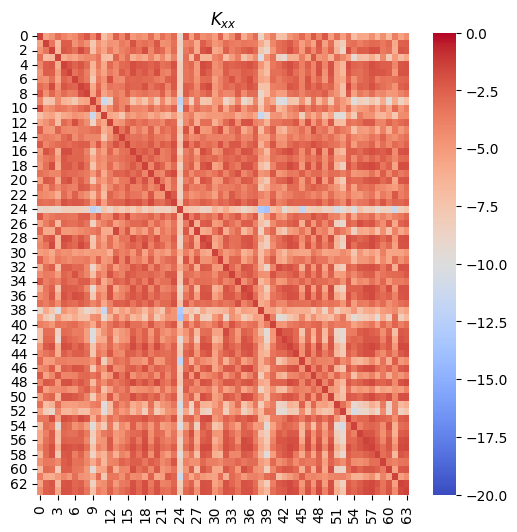

In [74]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_title(r"$K_{xx}$")
heatmap(np.log(K_xx+1e-12), ax=axes, cmap='coolwarm', cbar=True, vmin=-20, vmax=0)
plt.savefig("compare/elevators_kxx.png", bbox_inches='tight')

[tensor(0.9874), tensor(0.9572), tensor(0.9261), tensor(0.7925), tensor(0.6320), tensor(0.4311)]


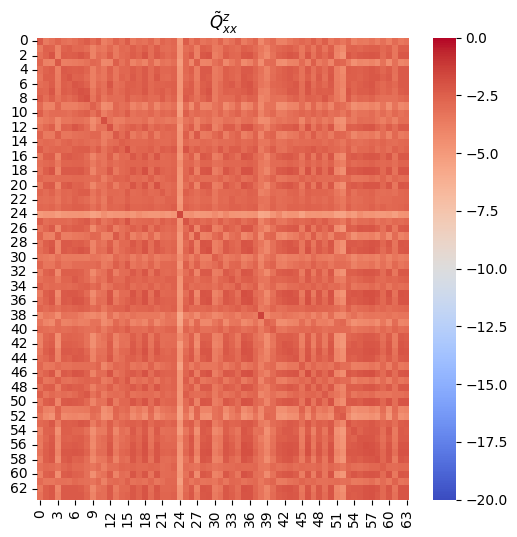

In [75]:
print(norms)
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_title(r"$\tilde{Q}_{xx}^z$")
heatmap(np.log(Q_xx+1e-12), ax=axes, cmap='coolwarm', cbar=True, vmin=-20, vmax=0)
plt.savefig("compare/elevators_qxx.png", bbox_inches='tight')

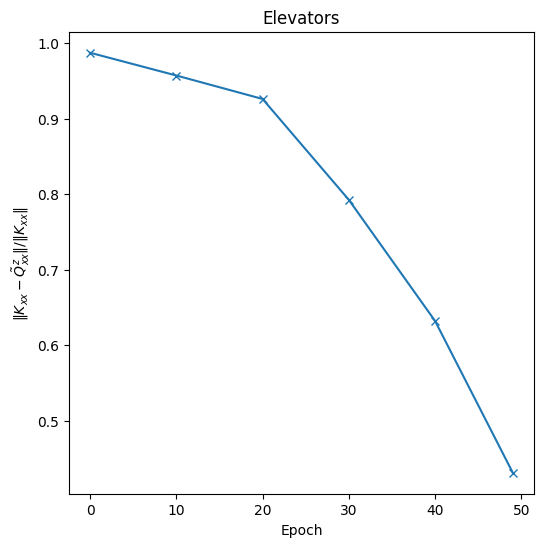

In [76]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
plt.plot([0, 10, 20, 30, 40, 49], norms, marker="x")
plt.title("Elevators")
plt.xlabel("Epoch")
plt.ylabel(r"$\|K_{xx} - \tilde{Q}_{xx}^z\| / \|K_{xx}\|$");
plt.savefig("compare/elevators_kxx_qxx_norm.png", bbox_inches='tight')

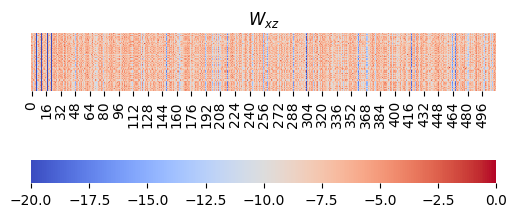

In [77]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_title(r"$W_{xz}$")
axes.set_aspect('equal')
heatmap(np.log(W_xz+1e-12), ax=axes, cmap='coolwarm', cbar=True, cbar_kws={"orientation": "horizontal"}, yticklabels=False, vmin=-20, vmax=0)
plt.savefig("compare/elevators_Wxz.png", bbox_inches='tight')

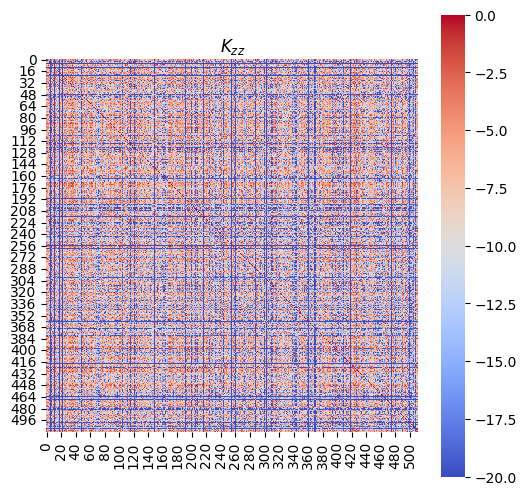

In [78]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_title(r"$K_{zz}$")
axes.set_aspect('equal')
heatmap(np.log(K_zz+1e-12), ax=axes, cmap='coolwarm', cbar=True, vmin=-20, vmax=0)
plt.savefig("compare/elevators_Kzz.png", bbox_inches='tight')

In [29]:
kernels, softgps, K_zzs = load("pol")

my_dataset = PoleteleDataset(f"../data/uci_datasets/uci_datasets/pol/data.csv")
# Generate splits
train_dataset, val_dataset, test_dataset = split_dataset(
    my_dataset,
    train_frac=0.9,
    val_frac=0.0
)
test_features, test_labels = flatten_dataset(test_dataset)
xs = test_features[0:128,:]

norms = []
with torch.no_grad():
    for idx, (kernel, softgp, K_zz) in enumerate(zip(kernels, softgps, K_zzs)):
        W_xz = softgp._interp(xs)
        Q_xx = W_xz @ K_zz @ W_xz.T
        K_xx = kernel(xs, xs).evaluate()
        norms += [torch.linalg.matrix_norm(K_xx - Q_xx, ord='fro') / torch.linalg.matrix_norm(K_xx, ord='fro')]

torch.Size([512, 26])
l 0.6326248049736023 s 0.7651041746139526
l 0.7184596657752991 s 0.6684596538543701
(512, 512) torch.Size([512, 26])
torch.Size([512, 26])
l 0.7479104995727539 s 1.518255352973938
l 1.0037484169006348 s 0.45737671852111816
(512, 512) torch.Size([512, 26])
torch.Size([512, 26])
l 0.6321961283683777 s 2.2726922035217285
l 1.3284575939178467 s 0.3105637729167938
(512, 512) torch.Size([512, 26])
torch.Size([512, 26])
l 0.5387281179428101 s 2.9679741859436035
l 1.6460185050964355 s 0.21769559383392334
(512, 512) torch.Size([512, 26])
torch.Size([512, 26])
l 0.4574849605560303 s 3.6189818382263184
l 1.91181480884552 s 0.16271916031837463
(512, 512) torch.Size([512, 26])
torch.Size([512, 26])
l 0.39682096242904663 s 4.162954330444336
l 2.1031441688537598 s 0.131681889295578
(512, 512) torch.Size([512, 26])
SIZE (15000, 27)


/tmp/ipykernel_2786727/824547403.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  softgp = SoftGP(skernel, inducing_points=torch.tensor(z), use_scale=True)


  0%|          | 0/1 [00:00<?, ?it/s]

[tensor(0.9317), tensor(0.8817), tensor(0.9220), tensor(1.0945), tensor(1.3582), tensor(1.6816)]


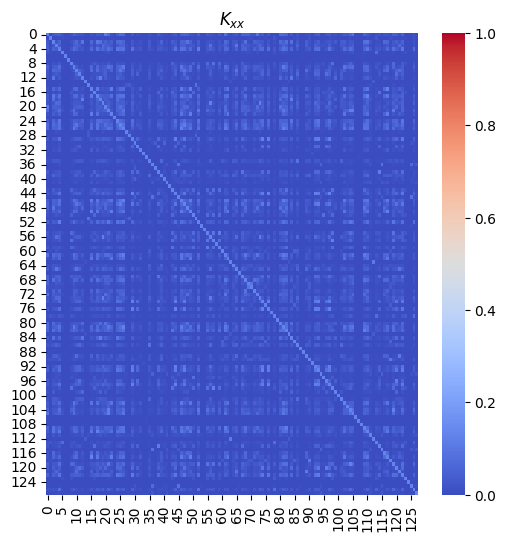

In [30]:
print(norms)
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_title(r"$K_{xx}$")
heatmap(K_xx, ax=axes, cmap='coolwarm', cbar=True, vmin=0.0, vmax=1)
plt.savefig("compare/pol_kxx.png")

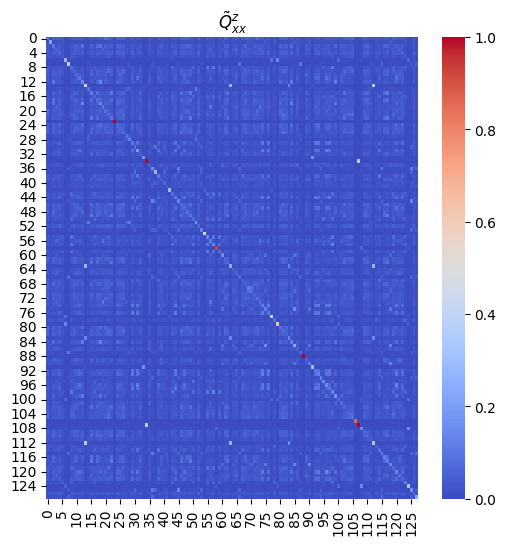

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_title(r"$\tilde{Q}_{xx}^z$")
heatmap(Q_xx, ax=axes, cmap='coolwarm', cbar=True, vmin=0.0, vmax=1)
plt.savefig("compare/pol_qxx.png")

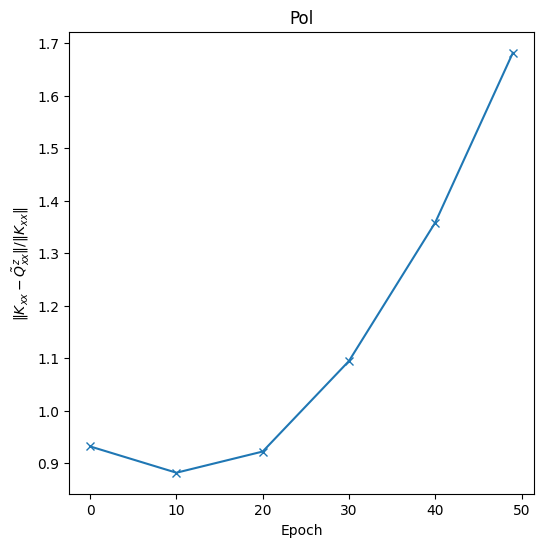

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
plt.plot([0, 10, 20, 30, 40, 49], norms, marker="x")
plt.title("Pol")
plt.xlabel("Epoch")
plt.ylabel(r"$\|K_{xx} - \tilde{Q}_{xx}^z\| / \|K_{xx}\|$");
plt.savefig("compare/pol_kxx_qxx_norm.png")

In [13]:
uci_dict[("pol", 6535, "exact")]["lengthscale"]

0     0.718460
1     0.744393
2     0.770940
3     0.798093
4     0.825840
        ...   
95    2.401776
96    2.399261
97    2.396346
98    2.392959
99    2.389384
Name: lengthscale, Length: 100, dtype: float64